In [318]:
import numpy as np
import pandas as pd
from __future__ import division
from scipy.stats import gamma

In [494]:
df = pd.read_csv("../Input/train_files/stock_prices.csv")
stock_list = pd.read_csv("../Input/stock_list.csv")


In [495]:
# df.drop(columns=['RowId'], inplace=True)

In [496]:
def reduce_mem_usage(df: pd.DataFrame,
                     verbose: bool = True) -> pd.DataFrame:
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == "int":
                if (c_min > np.iinfo(np.int8).min
                        and c_max < np.iinfo(np.int8).max):
                    df[col] = df[col].astype(np.int8)
                elif (c_min > np.iinfo(np.int16).min
                      and c_max < np.iinfo(np.int16).max):
                    df[col] = df[col].astype(np.int16)
                elif (c_min > np.iinfo(np.int32).min
                      and c_max < np.iinfo(np.int32).max):
                    df[col] = df[col].astype(np.int32)
                elif (c_min > np.iinfo(np.int64).min
                      and c_max < np.iinfo(np.int64).max):
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min
                      and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    reduction = (start_mem - end_mem) / start_mem

    msg = f"Mem. usage decreased to {end_mem:5.2f} MB" + \
        f" ({reduction * 100:.1f} % reduction)"
    if verbose:
        print(msg)

    return df


In [497]:
def get_time_info(df, is_onehot=False):
    datetime_series = pd.to_datetime(df['Date']).dt

    def get_weekday(dt_series, is_onehot=False):
        if is_onehot:
            return pd.get_dummies(dt_series.day_name())
        return dt_series.dayofweek

    def get_week(dt_series):
        return dt_series.isocalendar().week

    def get_month(dt_series, is_onehot=False):
        if is_onehot:
            return pd.get_dummies(dt_series.month_name())
        return dt_series.month

    weekday = get_weekday(datetime_series, is_onehot)
    week = get_week(datetime_series)
    month = get_month(datetime_series, is_onehot)

    if is_onehot:
        return pd.concat([df, weekday, week, month], axis=1)
    df['weekday'] = weekday
    df['week'] = week
    df['month'] = month
    return df

In [498]:
df = get_time_info(df)

In [499]:
print(df.shape)
print(df.isnull().sum())

(2332531, 15)
RowId                     0
Date                      0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
weekday                   0
week                      0
month                     0
dtype: int64


In [500]:
# df = df[~df['Target'].isnull()].reset_index(drop=True)
df['Target'].fillna(0, inplace=True)
df["high_rank"] = df.groupby("Date")["Target"].rank("dense", ascending=False).astype(int)

In [501]:
df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,weekday,week,month,high_rank
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,2,1,1,858
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324,2,1,1,316
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154,2,1,1,542
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053,2,1,1,355
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026,2,1,1,714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816,4,48,12,560
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478,4,48,12,1057
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302,4,48,12,1825
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098,4,48,12,1671


In [502]:
# df = reduce_mem_usage(df, True)

In [503]:
df.memory_usage(index = True)

Index                    128
RowId               18660248
Date                18660248
SecuritiesCode      18660248
Open                18660248
High                18660248
Low                 18660248
Close               18660248
Volume              18660248
AdjustmentFactor    18660248
ExpectedDividend    18660248
SupervisionFlag      2332531
Target              18660248
weekday             18660248
week                11662655
month               18660248
high_rank           18660248
dtype: int64

In [504]:
def append_lag_corr_code(df, target_col='Close', index='Date', columns='SecuritiesCode', period=1, is_unpivot=False):
    if is_unpivot:
        period *= 4
    pivot = df.pivot(index=index, columns=columns, values=target_col)
    pivot.fillna(method='ffill', inplace=True)
    pivot.interpolate(limit_direction='both', inplace=True)
    target = pivot.iloc[period:, :].values
    # target_lag = pivot.shift(period).iloc[period:, :].values
    target_lag = pivot.iloc[:-period, :].values

    diff = target - target.mean()
    lag_diff = target_lag - target_lag.mean()

    lag_corr = np.dot(diff.T, lag_diff) / (np.sqrt(sum(diff ** 2)) * np.sqrt(sum(lag_diff ** 2)))
    for i in range(lag_corr.shape[0]):
        lag_corr[i, i] = 0.0

    lag_idxmax = lag_corr.argmax(axis=1)
    lag_idxmin = lag_corr.argmin(axis=1)

    lag_corr_master = pd.DataFrame()
    lag_corr_master['SecuritiesCode'] = pivot.columns
    lag_corr_master = lag_corr_master.reset_index()

    lag_idxmax_dict = dict(zip(range(lag_corr_master.shape[0]), lag_idxmax))
    lag_idxmin_dict = dict(zip(range(lag_corr_master.shape[0]), lag_idxmin))
    code_master_dict = dict(zip(range(lag_corr_master.shape[0]),  pivot.columns))
    lag_corr_master['lag_max_corr_code'] = lag_corr_master['index'].map(lag_idxmax_dict)
    lag_corr_master['lag_min_corr_code'] = lag_corr_master['index'].map(lag_idxmin_dict)
    lag_corr_master[f'{target_col}_lag{period}_max_corr_code'] = lag_corr_master['lag_max_corr_code'].map(code_master_dict)
    lag_corr_master[f'{target_col}_lag{period}_min_corr_code'] = lag_corr_master['lag_min_corr_code'].map(code_master_dict)
    lag_corr_master = lag_corr_master[['SecuritiesCode', f'{target_col}_lag{period}_max_corr_code', f'{target_col}_lag{period}_min_corr_code']]

    return df.merge(lag_corr_master, on="SecuritiesCode", how="left")


In [505]:
def append_value_by_corr(df, target_col='', target_corr_cols=[], suffixes=('', '_corr'), is_rowid=False):
    # RowIDを使うように変更
    if is_rowid:
        target_dict = dict(zip(df['RowId'], df[target_col]))
        if isinstance(target_corr_cols, list):
            for col in target_corr_cols:
                df[f'{col}_RowId'] = df['Date'] + '_' + df[col]
                target_corr_col = col[:-5]
                df[target_corr_col] = df[f'{col}_RowId'].map(target_dict)
        df['RowId'].map()
    return df.merge(
                df[['Date', 'SecuritiesCode', target_col]],
                left_on=['Date', target_corr_cols],
                right_on=['Date', 'SecuritiesCode'],
                uffixes=('', '_corr')
            )

In [506]:
def unpivot_price(df):
    unpivot_df = pd.melt(
        df[['Date', 'SecuritiesCode', 'Open',	'High', 'Low', 'Close']],
        id_vars=['Date', 'SecuritiesCode'],
        value_vars=['Open',	'High', 'Low', 'Close']
        )
    return unpivot_df.sort_values(['Date', 'SecuritiesCode']).reset_index(drop=True)

In [507]:
def calc_unpivot_target(df, method='original'):
    unpivot_df = unpivot_price(df)
    unpivot_df = unpivot_df.merge(df[['Date', 'SecuritiesCode', 'Target', 'high_rank']], on=['Date', 'SecuritiesCode'], how='left')
    if method == 'original':
        return unpivot_df
    unpivot_group = unpivot_df.groupby(['SecuritiesCode', 'variable'])
    unpivot_df['Target'] = (unpivot_group['value'].diff() / unpivot_group.shift(1)['value'])
    unpivot_df['Target'].fillna(0, inplace=True)
    return unpivot_df

In [508]:
# unpivot_df = calc_unpivot_target(df)

In [509]:
# unpivot_df

In [510]:
# sup_stock_prices = pd.read_csv("../Input/supplemental_files/stock_prices.csv")

In [511]:
# sup_stock_prices.shape

In [512]:
df['SecuritiesCode'].sort_values().unique()[df.groupby(['SecuritiesCode'])['Volume'].mean() < 1000]

array([2761, 4365, 4781, 9441, 9537, 9733])

In [513]:
unpivot_df = calc_unpivot_target(df, method='calc')

In [514]:
df.Target.sort_values(ascending=False)[:10000]

441408     1.119512
2206104    0.618238
217810     0.585366
241336     0.575264
1152661    0.481348
             ...   
1521843    0.095023
2234459    0.095017
1779321    0.095016
2113170    0.095010
1281314    0.095006
Name: Target, Length: 10000, dtype: float64

In [515]:
df[df['Close'].isnull()]

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,weekday,week,month,high_rank
401,20170104_3540,2017-01-04,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000,2,1,1,879
1753,20170104_9539,2017-01-04,9539,NaN,NaN,NaN,NaN,0,1.0,NaN,False,-0.004149,2,1,1,1083
2266,20170105_3540,2017-01-05,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000,3,1,1,682
2511,20170105_4621,2017-01-05,4621,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000,3,1,1,682
4131,20170106_3540,2017-01-06,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000,4,1,1,879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330563,20211203_1787,2021-12-03,1787,NaN,NaN,NaN,NaN,0,1.0,NaN,False,-0.030351,4,48,12,1869
2330786,20211203_2761,2021-12-03,2761,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000,4,48,12,1798
2331453,20211203_5918,2021-12-03,5918,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.015625,4,48,12,1494
2332336,20211203_9083,2021-12-03,9083,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.009615,4,48,12,1664


In [516]:
stock_list['SecuritiesCode'] == 3540

0       False
1       False
2       False
3       False
4       False
        ...  
4412    False
4413    False
4414    False
4415    False
4416    False
Name: SecuritiesCode, Length: 4417, dtype: bool

In [517]:
df[(df['SecuritiesCode'] == 3540) & (df['Open'].isnull())]

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,weekday,week,month,high_rank
401,20170104_3540,2017-01-04,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000,2,1,1,879
2266,20170105_3540,2017-01-05,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000,3,1,1,682
4131,20170106_3540,2017-01-06,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000,4,1,1,879
5996,20170110_3540,2017-01-10,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000,1,2,1,320
7861,20170111_3540,2017-01-11,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000,2,2,1,1101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435744,20171211_3540,2017-12-11,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,True,0.000000,0,50,12,707
437631,20171212_3540,2017-12-12,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,True,0.000000,1,50,12,1180
439519,20171213_3540,2017-12-13,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,True,0.000000,2,50,12,613
441408,20171214_3540,2017-12-14,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,True,1.119512,3,50,12,1


In [518]:
df[(df['SecuritiesCode'] == 3540) & (~df['Open'].isnull())]

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,weekday,week,month,high_rank
443298,20171215_3540,2017-12-15,3540,2050.0,2050.0,2050.0,2050.0,700,1.0,NaN,True,0.162255,4,50,12,2
445188,20171218_3540,2017-12-18,3540,4030.0,4630.0,4010.0,4345.0,1559200,1.0,NaN,True,-0.065347,0,51,12,1758
447078,20171219_3540,2017-12-19,3540,4300.0,5050.0,4265.0,5050.0,799200,1.0,NaN,True,0.042373,1,51,12,44
448968,20171220_3540,2017-12-20,3540,5250.0,5330.0,4430.0,4720.0,1152200,1.0,NaN,True,0.036585,2,51,12,53
450860,20171221_3540,2017-12-21,3540,4850.0,5200.0,4730.0,4920.0,344300,1.0,NaN,True,-0.027451,3,51,12,1674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322948,20211129_3540,2021-11-29,3540,5000.0,5130.0,4980.0,4980.0,13000,1.0,NaN,True,0.055966,0,48,11,16
2324948,20211130_3540,2021-11-30,3540,5010.0,5050.0,4725.0,4735.0,21800,1.0,NaN,True,-0.026000,1,48,11,1537
2326948,20211201_3540,2021-12-01,3540,4735.0,5040.0,4710.0,5000.0,27300,1.0,NaN,True,0.022587,2,48,12,910
2328948,20211202_3540,2021-12-02,3540,4900.0,4985.0,4855.0,4870.0,12300,1.0,NaN,True,0.001004,3,48,12,729


In [519]:
financials = pd.read_csv('../Input/train_files/financials.csv')

/var/folders/ym/2nhqmm5d6zn8mfrndqmv6l_40000gn/T/ipykernel_47634/3245139718.py:1: DtypeWarning: Columns (14,15,16,17,18,19,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  financials = pd.read_csv('../Input/train_files/financials.csv')


In [520]:
financials

,DisclosureNumber,DateCode,Date,SecuritiesCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,...,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,2.016121e+13,20170104_2753,2017-01-04,2753.0,2017-01-04,07:30:00,1.483483e+09,3QFinancialStatements_Consolidated_JP,2016-12-31,3Q,...,319.76,NaN,False,True,False,False,False,6848800.0,－,6848800.0
1,2.017010e+13,20170104_3353,2017-01-04,3353.0,2017-01-04,15:00:00,1.483510e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,485.36,NaN,False,True,False,False,False,2035000.0,118917,1916083.0
2,2.016123e+13,20170104_4575,2017-01-04,4575.0,2017-01-04,12:00:00,1.483499e+09,ForecastRevision,2016-12-31,2Q,...,-93.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.017010e+13,20170105_2659,2017-01-05,2659.0,2017-01-05,15:00:00,1.483596e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,285.05,NaN,False,True,False,False,False,31981654.0,18257,31963405.0
4,2.017011e+13,20170105_3050,2017-01-05,3050.0,2017-01-05,15:30:00,1.483598e+09,ForecastRevision,2017-02-28,FY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92951,2.021112e+13,20211203_6040,2021-12-03,6040.0,2021-12-03,15:00:00,1.638511e+09,1QFinancialStatements_Consolidated_JP,2021-10-31,1Q,...,－,NaN,False,True,False,False,False,16000400.0,836400,15164000.0
92952,2.021120e+13,20211203_6898,2021-12-03,6898.0,2021-12-03,16:00:00,1.638515e+09,3QFinancialStatements_Consolidated_JP,2021-10-31,3Q,...,142.01,NaN,False,False,False,False,False,816979.0,157541,659486.0
92953,2.021120e+13,20211203_6969,2021-12-03,6969.0,2021-12-03,15:00:00,1.638511e+09,ForecastRevision,2022-03-31,FY,...,-147.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92954,2.021112e+13,20211203_8057,2021-12-03,8057.0,2021-12-03,17:00:00,1.638518e+09,1QFinancialStatements_Consolidated_JP,2021-10-20,1Q,...,330.92,NaN,False,True,False,False,False,10419371.0,614032,9805339.0


In [521]:
financials.columns

Index(['DisclosureNumber', 'DateCode', 'Date', 'SecuritiesCode',
       'DisclosedDate', 'DisclosedTime', 'DisclosedUnixTime', 'TypeOfDocument',
       'CurrentPeriodEndDate', 'TypeOfCurrentPeriod',
       'CurrentFiscalYearStartDate', 'CurrentFiscalYearEndDate', 'NetSales',
       'OperatingProfit', 'OrdinaryProfit', 'Profit', 'EarningsPerShare',
       'TotalAssets', 'Equity', 'EquityToAssetRatio', 'BookValuePerShare',
       'ResultDividendPerShare1stQuarter', 'ResultDividendPerShare2ndQuarter',
       'ResultDividendPerShare3rdQuarter',
       'ResultDividendPerShareFiscalYearEnd', 'ResultDividendPerShareAnnual',
       'ForecastDividendPerShare1stQuarter',
       'ForecastDividendPerShare2ndQuarter',
       'ForecastDividendPerShare3rdQuarter',
       'ForecastDividendPerShareFiscalYearEnd',
       'ForecastDividendPerShareAnnual', 'ForecastNetSales',
       'ForecastOperatingProfit', 'ForecastOrdinaryProfit', 'ForecastProfit',
       'ForecastEarningsPerShare',
       'ApplyingOf

In [522]:
first_date = financials[financials['SecuritiesCode'] == 3540]['DisclosedDate'].iloc[0]

In [523]:
first_date

'2018-02-13'

In [524]:
import datetime
pd.to_datetime(first_date) - pd.Timedelta(days=90) 

Timestamp('2017-11-15 00:00:00')

In [525]:
unpivot_df.isnull().sum()

Date                  0
SecuritiesCode        0
variable              0
value             30432
Target                0
high_rank             0
dtype: int64

In [526]:
unpivot_df[unpivot_df['value'].isnull()]

,Date,SecuritiesCode,variable,value,Target,high_rank
1604,2017-01-04,3540,Open,NaN,0.0,879
1605,2017-01-04,3540,High,NaN,0.0,879
1606,2017-01-04,3540,Low,NaN,0.0,879
1607,2017-01-04,3540,Close,NaN,0.0,879
7012,2017-01-04,9539,Open,NaN,0.0,1083
...,...,...,...,...,...,...
9329347,2021-12-03,9083,Close,NaN,0.0,1664
9329848,2021-12-03,9733,Open,NaN,0.0,1798
9329849,2021-12-03,9733,High,NaN,0.0,1798
9329850,2021-12-03,9733,Low,NaN,0.0,1798


In [527]:
df['SupervisionFlag'].value_counts()

False    2331036
True        1495
Name: SupervisionFlag, dtype: int64

# append_lag_corr_codeはunpivotする前に実行する
# 同じ銘柄のOpen, Closeの間の相関が高すぎるので

# append_lag_corr_codeの挙動がバグっぽいので調べる

In [531]:
Open_lag1_corr = append_lag_corr_code(df, target_col='Open')
Close_lag1_corr = append_lag_corr_code(df, target_col='Close')
Target_lag1_corr = append_lag_corr_code(df, target_col='Target')
high_rank_lag1_corr = append_lag_corr_code(df, target_col='high_rank')

In [536]:
dict(zip(df['RowId'], df['Open']))

{'20170104_1301': 2734.0,
 '20170104_1332': 568.0,
 '20170104_1333': 3150.0,
 '20170104_1376': 1510.0,
 '20170104_1377': 3270.0,
 '20170104_1379': 2105.0,
 '20170104_1381': 1950.0,
 '20170104_1407': 857.0,
 '20170104_1414': 4940.0,
 '20170104_1417': 1051.0,
 '20170104_1419': 526.0,
 '20170104_1429': 418.0,
 '20170104_1435': 4165.0,
 '20170104_1515': 5610.0,
 '20170104_1518': 1298.0,
 '20170104_1605': 1182.5,
 '20170104_1662': 2629.0,
 '20170104_1663': 1844.0,
 '20170104_1712': 1458.0,
 '20170104_1716': 998.0,
 '20170104_1719': 783.0,
 '20170104_1720': 937.0,
 '20170104_1721': 2154.0,
 '20170104_1723': 2033.0,
 '20170104_1726': 254.0,
 '20170104_1762': 2490.0,
 '20170104_1766': 8330.0,
 '20170104_1775': 329.0,
 '20170104_1780': 562.0,
 '20170104_1787': 1204.0,
 '20170104_1793': 796.0,
 '20170104_1799': 1168.0,
 '20170104_1801': 836.0,
 '20170104_1802': 1125.0,
 '20170104_1803': 1079.0,
 '20170104_1805': 186.0,
 '20170104_1808': 1190.0,
 '20170104_1810': 1064.0,
 '20170104_1811': 510.0,


In [532]:
df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,weekday,week,month,high_rank
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,2,1,1,858
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324,2,1,1,316
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154,2,1,1,542
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053,2,1,1,355
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026,2,1,1,714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816,4,48,12,560
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478,4,48,12,1057
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302,4,48,12,1825
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098,4,48,12,1671


In [530]:
append_value_by_corr(Open_lag1_corr, target_col='Open', target_corr_cols='Open_lag1_max_corr_code')

TypeError: append_value_by_corr() got an unexpected keyword argument 'target_corr_col'

In [486]:
Open_lag1_corr

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,weekday,week,month,high_rank,Open_lag1_max_corr_code,Open_lag1_min_corr_code
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,2,1,1,858,4994,7679
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324,2,1,1,316,7679,7351
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154,2,1,1,542,4994,4973
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053,2,1,1,355,7679,7351
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026,2,1,1,714,7351,7679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816,4,48,12,560,7679,7351
2332527,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478,4,48,12,1057,7679,7351
2332528,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302,4,48,12,1825,7679,7351
2332529,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098,4,48,12,1671,2830,4665


In [ ]:
Open_lag1_corr[['Open_lag1_max_corr_code', ]]

In [491]:
Open_lag1_corr.merge(Open_lag1_corr[['Date', 'SecuritiesCode', 'Open']], left_on=['Date', 'Open_lag1_max_corr_code'], right_on=['Date', 'SecuritiesCode'], suffixes=('', '_corr'))

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,weekday,week,month,high_rank,Open_lag1_max_corr_code,Open_lag1_min_corr_code,SecuritiesCode_corr,Open_corr
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,2,1,1,858,4994,7679,4994,3160.0
1,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154,2,1,1,542,4994,4973,4994,3160.0
2,2017-01-04,1414,4940.0,5060.0,4935.0,5050.0,119600,1.0,NaN,False,0.000000,2,1,1,879,4994,7679,4994,3160.0
3,2017-01-04,1515,5610.0,5740.0,5560.0,5720.0,25200,1.0,NaN,False,-0.026502,2,1,1,1630,4994,7679,4994,3160.0
4,2017-01-04,1801,836.0,837.0,826.0,835.0,5077000,1.0,NaN,False,0.009581,2,1,1,402,4994,7679,4994,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513785,2021-12-03,6929,2857.0,2888.0,2841.0,2878.0,37500,1.0,NaN,False,0.028213,4,48,12,915,8850,7339,8850,2453.0
1513786,2021-12-03,7292,2686.0,2705.0,2667.0,2694.0,1300,1.0,NaN,False,-0.016300,4,48,12,1856,8850,7339,8850,2453.0
1513787,2021-12-03,7011,2554.0,2619.5,2551.0,2619.0,2464400,1.0,NaN,False,0.028642,4,48,12,886,5945,7679,5945,3145.0
1513788,2021-12-03,8919,4295.0,4430.0,4265.0,4415.0,153400,1.0,NaN,False,0.036697,4,48,12,488,5945,7679,5945,3145.0


In [346]:
corr_df = Open_lag1_corr[['Date', 'SecuritiesCode', 'Open']]
df = Open_lag1_corr.merge(corr_df, right_on=['Date', 'Open_lag1_max_corr_code'], left_on=['Date', 'SecuritiesCode'])
df = Open_lag1_corr.merge(corr_df, right_on=['Date', 'Open_lag1_min_corr_code'], left_on=['Date', 'SecuritiesCode'])

corr_df = Close_lag1_corr[['Date', 'SecuritiesCode', 'Close']]
df = Close_lag1_corr.merge(corr_df, right_on=['Date', 'Close_lag1_max_corr_code'], left_on=['Date', 'SecuritiesCode'])
df = Close_lag1_corr.merge(corr_df, right_on=['Date', 'Close_lag1_min_corr_code'], left_on=['Date', 'SecuritiesCode'])

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,weekday,week,month,high_rank,Open_lag1_max_corr_code,Open_lag1_min_corr_code
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,2,1,1,858,4994,7679
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324,2,1,1,316,7679,7351
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154,2,1,1,542,4994,4973
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053,2,1,1,355,7679,7351
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026,2,1,1,714,7351,7679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816,4,48,12,560,7679,7351
2332527,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478,4,48,12,1057,7679,7351
2332528,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302,4,48,12,1825,7679,7351
2332529,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098,4,48,12,1671,2830,4665


In [353]:
Open_lag1_corr.Open_lag1_min_corr_code.value_counts()

7351    916642
7679    409881
7339    231381
4994    219850
4665    190007
9537     60321
9007     42602
4973     39034
7451     27646
1721     24158
2871     23623
2270     21636
2809     17745
4327     13222
2830     13222
4547     11355
4726      8175
4551      7212
2742      6973
8160      6436
5945      6010
2664      6010
1951      4607
6436      2404
7354      2404
4538      2404
4832      2404
6849      2404
8801      1615
9433      1202
1941      1202
7966      1202
2831      1202
9551      1202
4528      1202
7447      1202
8218      1202
2669      1202
8058       330
Name: Open_lag1_min_corr_code, dtype: int64

In [485]:
Close_lag1_corr

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,weekday,week,month,high_rank,Close_lag1_max_corr_code,Close_lag1_min_corr_code
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,2,1,1,858,4994,7679
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324,2,1,1,316,7679,4994
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154,2,1,1,542,4994,4973
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053,2,1,1,355,7679,4994
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026,2,1,1,714,4994,7679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816,4,48,12,560,7679,4665
2332527,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478,4,48,12,1057,7679,4994
2332528,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302,4,48,12,1825,7679,4665
2332529,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098,4,48,12,1671,2830,4665


In [480]:
Close_lag1_corr.Close_lag1_min_corr_code.nunique()

44

In [481]:
Target_lag1_corr.Target_lag1_max_corr_code.nunique()

154

In [482]:
Target_lag1_corr.Target_lag1_min_corr_code.nunique()

201

In [483]:
high_rank_lag1_corr.high_rank_lag1_max_corr_code.nunique()

827

In [484]:
high_rank_lag1_corr.high_rank_lag1_min_corr_code.nunique()

833

In [99]:
df

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,high_rank
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,858
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324,316
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154,542
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053,355
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026,714
...,...,...,...,...,...,...,...,...,...,...,...,...
2332288,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816,560
2332289,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478,1057
2332290,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302,1825
2332291,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098,1671


In [ ]:
unpivot_df.to_parquet('../Output/unpivot_df.parquet')

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<AxesSubplot:>

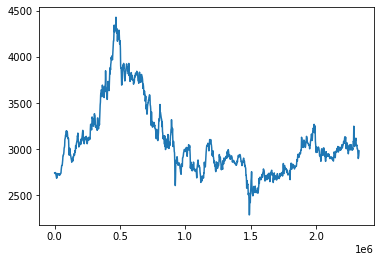

In [221]:
df[df['SecuritiesCode'] == 1301]['Close'].plot()

<AxesSubplot:>

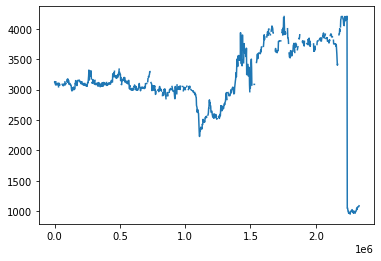

In [220]:
df[df['SecuritiesCode'] == 4781]['Close'].plot()

In [ ]:
import time

from contextlib import contextmanager

@contextmanager
def timer(name: str):
    t0 = time.time()
    msg = f"[{name}] start"
    print(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    print(msg)


In [ ]:
# # MIC相関行列用に空のデータフレームを作成
# df_mic = pd.DataFrame(columns=pivot_target.columns, index=pivot_target.columns)

# # forループ内でMIC相関係数を求め，先ほどのデータフレームに格納
# for column in tqdm(pivot_target.columns):

#     for index in pivot_target.columns:

#         # MIC相関係数の計算
#         mine.compute_score(pivot_target[column], pivot_target[index])
#         # 計算結果をデータフレームに書き込み
#         df_mic.loc[index, column] = mine.mic()

  1%|          | 12/2000 [11:20<31:17:54, 56.68s/it]


KeyboardInterrupt: 

In [ ]:
df.groupby('SecuritiesCode')['high_rank'].mean().sort_values()

SecuritiesCode
6920     819.786190
6532     834.020799
2127     843.186356
3762     846.490849
3288     846.490849
           ...     
4425    1015.006974
6612    1019.565401
4883    1023.507599
4167    1029.110638
4493    1037.289157
Name: high_rank, Length: 2000, dtype: float64

In [ ]:
df.groupby('SecuritiesCode')['Target'].mean().sort_values()

SecuritiesCode
4883   -0.002648
4056   -0.002228
4058   -0.001572
4382   -0.001536
1375   -0.001486
          ...   
7094    0.005427
4880    0.005452
7095    0.005846
4051    0.006344
4169    0.008299
Name: Target, Length: 2000, dtype: float64